# Lightweight BackTesting

Author: Mohammad Yousuf Hussain <br>
Credits: Alexandr Honchar

### Importing Packages

In [60]:

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Merge, Input, concatenate, GaussianNoise
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

### Loading Data

In [3]:
bars = pd.read_csv('dataset/price_11contracts.csv' , header=0, parse_dates=['date'])

In [7]:
from IPython.display import display, clear_output

display(bars.head())
display(bars.tail())

,Unnamed: 0,date,openEUR,highEUR,lowEUR,closeEUR,volumeEUR,barCountEUR,averageEUR,openJPY,...,volumeYM,barCountYM,averageYM,openES,highES,lowES,closeES,volumeES,barCountES,averageES
0,0,2018-01-16 22:40:00,1.221025,1.221075,1.219975,1.220625,-1,-1,-1.0,110.7425,...,7,5,26046.4,2808.25,2811.25,2808.00,2809.75,66,45,2809.375
1,1,2018-01-16 22:50:00,1.220625,1.221475,1.220525,1.220875,-1,-1,-1.0,110.8400,...,4,4,26055.7,2810.25,2812.00,2809.50,2810.50,62,32,2810.575
2,2,2018-01-16 23:00:00,1.220875,1.222125,1.220725,1.222075,-1,-1,-1.0,110.8175,...,0,0,26068.0,2810.00,2810.00,2808.00,2808.50,38,19,2808.775
3,3,2018-01-16 23:10:00,1.222075,1.222175,1.221575,1.222175,-1,-1,-1.0,110.7675,...,2,2,26066.5,2808.75,2810.00,2808.75,2809.75,27,10,2809.175
4,4,2018-01-16 23:20:00,1.222175,1.222575,1.221575,1.221625,-1,-1,-1.0,110.8175,...,4,3,26050.0,2809.75,2809.75,2806.50,2806.75,41,26,2807.650


,Unnamed: 0,date,openEUR,highEUR,lowEUR,closeEUR,volumeEUR,barCountEUR,averageEUR,openJPY,...,volumeYM,barCountYM,averageYM,openES,highES,lowES,closeES,volumeES,barCountES,averageES
2665,2665,2018-04-21 03:30:00,1.228125,1.228375,1.228075,1.228275,-1,-1,-1.0,107.5875,...,3638,2026,24377.5,2664.00,2668.25,2661.75,2667.25,30661,4806,2665.150
2666,2666,2018-04-21 03:40:00,1.228275,1.228375,1.228075,1.228300,-1,-1,-1.0,107.5850,...,4370,2273,24389.7,2667.25,2669.00,2663.75,2666.50,39882,5287,2666.400
2667,2667,2018-04-21 03:50:00,1.228300,1.228400,1.228075,1.228125,-1,-1,-1.0,107.6050,...,7191,3537,24407.5,2666.50,2671.00,2664.00,2670.50,104675,9257,2668.400
2668,2668,2018-04-21 04:00:00,1.228125,1.228350,1.228000,1.228275,-1,-1,-1.0,107.6475,...,3529,1826,24437.9,2670.50,2673.25,2669.25,2671.00,62146,4849,2671.175
2669,2669,2018-04-21 04:10:00,1.228275,1.228725,1.228275,1.228625,-1,-1,-1.0,107.6425,...,902,511,24437.8,2671.00,2673.25,2671.00,2672.25,16355,2033,2671.975


### Configuring Parameters

In [42]:
START_TRAIN_DATE = '2018-01-16 22:40:00'
END_TRAIN_DATE = '2018-02-16 22:40:00'
START_TEST_DATE = '2018-02-16 22:50:00'
END_TEST_DATE = '2018-04-21 04:10:00'
LOOKBACK = 7
STEP = 1
FORECAST = 1
INIT_CAPITAL = 10000
STAKE = 10

### Creating train/test dataset

In [176]:
train_set = bars[(bars['date'] > START_TRAIN_DATE) & (bars['date'] < END_TRAIN_DATE)]

In [177]:
test_set = bars[(bars['date'] > START_TEST_DATE) & (bars['date'] < END_TEST_DATE)]

In [185]:

def create_dataset(data):
    
    highp = pd.to_numeric(data.loc[:, 'highES'])
    high01 = pd.to_numeric(data.loc[:, 'highEUR'])
    high02 = pd.to_numeric(data.loc[:, 'highJPY'])
    high03 = pd.to_numeric(data.loc[:, 'highVIXF'])
    high04 = pd.to_numeric(data.loc[:, 'highVIXN'])
    high05 = pd.to_numeric(data.loc[:, 'highGC'])
    high06 = pd.to_numeric(data.loc[:, 'highZB'])
    high07 = pd.to_numeric(data.loc[:, 'highZN'])
    high08 = pd.to_numeric(data.loc[:, 'highZT'])
    high09 = pd.to_numeric(data.loc[:, 'highNQ'])
    high10 = pd.to_numeric(data.loc[:, 'highYM'])
    lowp = pd.to_numeric(data.loc[:, 'lowES'])
    low01 = pd.to_numeric(data.loc[:, 'lowEUR'])
    low02 = pd.to_numeric(data.loc[:, 'lowJPY'])
    low03 = pd.to_numeric(data.loc[:, 'lowVIXF'])
    low04 = pd.to_numeric(data.loc[:, 'lowVIXN'])
    low05 = pd.to_numeric(data.loc[:, 'lowGC'])
    low06 = pd.to_numeric(data.loc[:, 'lowZB'])
    low07 = pd.to_numeric(data.loc[:, 'lowZN'])
    low08 = pd.to_numeric(data.loc[:, 'lowZT'])
    low09 = pd.to_numeric(data.loc[:, 'lowNQ'])
    low10 = pd.to_numeric(data.loc[:, 'lowYM'])
    openp = pd.to_numeric(data.loc[:, 'openES'])
    open01 = pd.to_numeric(data.loc[:, 'openEUR'])
    open02 = pd.to_numeric(data.loc[:, 'openJPY'])
    open03 = pd.to_numeric(data.loc[:, 'openVIXF'])
    open04 = pd.to_numeric(data.loc[:, 'openVIXN'])
    open05 = pd.to_numeric(data.loc[:, 'openGC'])
    open06 = pd.to_numeric(data.loc[:, 'openZB'])
    open07 = pd.to_numeric(data.loc[:, 'openZN'])
    open08 = pd.to_numeric(data.loc[:, 'openZT'])
    open09 = pd.to_numeric(data.loc[:, 'openNQ'])
    open10 = pd.to_numeric(data.loc[:, 'openYM'])
    closep = pd.to_numeric(data.loc[:, 'closeES'])
    close01 = pd.to_numeric(data.loc[:, 'closeEUR'])
    close02 = pd.to_numeric(data.loc[:, 'closeJPY'])
    close03 = pd.to_numeric(data.loc[:, 'closeVIXF'])
    close04 = pd.to_numeric(data.loc[:, 'closeVIXN'])
    close05 = pd.to_numeric(data.loc[:, 'closeGC'])
    close06 = pd.to_numeric(data.loc[:, 'closeZB'])
    close07 = pd.to_numeric(data.loc[:, 'closeZN'])
    close08 = pd.to_numeric(data.loc[:, 'closeZT'])
    close09 = pd.to_numeric(data.loc[:, 'closeNQ'])
    close10 = pd.to_numeric(data.loc[:, 'closeYM'])
    volumep = pd.to_numeric(data.loc[:, 'volumeES'])

    normal_close = closep.values.tolist()
    normal_open = openp.values.tolist()

    highp = highp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high01 = high01.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high02 = high02.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high03 = high03.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high04 = high04.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high05 = high05.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high06 = high06.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high07 = high07.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high08 = high08.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high09 = high09.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    high10 = high10.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    lowp = lowp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low01 = low01.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low02 = low02.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low03 = low03.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low04 = low04.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low05 = low05.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low06 = low06.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low07 = low07.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low08 = low08.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low09 = low09.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    low10 = low10.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    openp = openp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open01 = open01.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open02 = open02.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open03 = open03.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open04 = open04.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open05 = open05.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open06 = open06.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open07 = open07.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open08 = open08.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open09 = open09.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    open10 = open10.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    closep = closep.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close01 = close01.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close02 = close02.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close03 = close03.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close04 = close04.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close05 = close05.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close06 = close06.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close07 = close07.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close08 = close08.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close09 = close09.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    close10 = close10.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    volumep = volumep.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()

    X, Y = [], []
    
    for i in range(0, len(data), STEP): 
        try:
            o = openp[i:i+LOOKBACK]
            o01 = open01[i:i+LOOKBACK]
            o02 = open02[i:i+LOOKBACK]
            o03 = open03[i:i+LOOKBACK]
            o04 = open04[i:i+LOOKBACK]
            o05 = open05[i:i+LOOKBACK]
            o06 = open06[i:i+LOOKBACK]
            o07 = open07[i:i+LOOKBACK]
            o08 = open08[i:i+LOOKBACK]
            o09 = open09[i:i+LOOKBACK]
            o10 = open10[i:i+LOOKBACK]
            h = highp[i:i+LOOKBACK]
            h01 = high01[i:i+LOOKBACK]
            h02 = high02[i:i+LOOKBACK]
            h03 = high03[i:i+LOOKBACK]
            h04 = high04[i:i+LOOKBACK]
            h05 = high05[i:i+LOOKBACK]
            h06 = high06[i:i+LOOKBACK]
            h07 = high07[i:i+LOOKBACK]
            h08 = high08[i:i+LOOKBACK]
            h09 = high09[i:i+LOOKBACK]
            h10 = high10[i:i+LOOKBACK]
            l = lowp[i:i+LOOKBACK]
            l01 = low01[i:i+LOOKBACK]
            l02 = low02[i:i+LOOKBACK]
            l03 = low03[i:i+LOOKBACK]
            l04 = low04[i:i+LOOKBACK]
            l05 = low05[i:i+LOOKBACK]
            l06 = low06[i:i+LOOKBACK]
            l07 = low07[i:i+LOOKBACK]
            l08 = low08[i:i+LOOKBACK]
            l09 = low09[i:i+LOOKBACK]
            l10 = low10[i:i+LOOKBACK]
            c = closep[i:i+LOOKBACK]
            c01 = close01[i:i+LOOKBACK]
            c02 = close02[i:i+LOOKBACK]
            c03 = close03[i:i+LOOKBACK]
            c04 = close04[i:i+LOOKBACK]
            c05 = close05[i:i+LOOKBACK]
            c06 = close06[i:i+LOOKBACK]
            c07 = close07[i:i+LOOKBACK]
            c08 = close08[i:i+LOOKBACK]
            c09 = close09[i:i+LOOKBACK]
            c10 = close10[i:i+LOOKBACK]
            v = volumep[i:i+LOOKBACK]

            y_i = (normal_close[i+LOOKBACK+FORECAST] - normal_open[i+LOOKBACK]) / normal_open[i+LOOKBACK]
            y_i = 1 if y_i > 0 else 0
            
            x_i = np.column_stack((o, o01, o02, o03, o04, o05, o06, o07, o08, o09, o10,
                                   h, h01, h02, h03, h04, h05, h06, h07, h08, h09, h10,
                                   l, l01, l02, l03, l04, l05, l06, l07, l08, l09, l10,
                                   c, c01, c02, c03, c04, c05, c06, c07, c08, c09, c10,
                                   v))
    
        except Exception as e:
            break

        X.append(x_i)
        Y.append(y_i)

    X, Y = np.array(X), np.array(Y)
    return X, Y

In [186]:
X_train, Y_train = create_dataset(train_set)
X_test, Y_test = create_dataset(test_set)

In [187]:
X_train.shape[-1]

45

### Defining Accuracy/Loss Plot Function

In [188]:
def plot_history(history):
    # summarize history for accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.axhline(y=0.5, color='grey', linestyle='--')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.axhline(y=0.693, color='grey', linestyle='--')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Modeling Neural Network

In [189]:
def get_lr_model(x1, x2):
    main_input = Input(shape=(x1, x2, ), name='main_input')
    x = GaussianNoise(0.01)(main_input)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation = "sigmoid", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer=Adam(lr=0.001, amsgrad=True),  loss='binary_crossentropy', metrics = ['accuracy'])
    return final_model

In [190]:
def get_LSTM_model(x1, x2):
    main_input = Input(shape=(x1, x2, ), name='main_input')
    x = GaussianNoise(0.01)(main_input)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation = "sigmoid", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer=Adam(lr=0.001, amsgrad=True),  loss='binary_crossentropy', metrics = ['accuracy'])
    return final_model

In [203]:
def get_LSTM_model(WINDOW, EMB_SIZE):
    model = Sequential()
    model.add(LSTM(units = WINDOW, input_shape=(WINDOW, EMB_SIZE),return_sequences=True))
    model.add(GaussianNoise(0.01))
    model.add(LSTM(units = EMB_SIZE * 2, input_shape=(WINDOW, EMB_SIZE),return_sequences=True))
    model.add(LSTM(units = WINDOW * 3, input_shape=(WINDOW, EMB_SIZE),return_sequences=True))
    model.add(LSTM(units = EMB_SIZE * 4, input_shape=(WINDOW, EMB_SIZE),return_sequences=True))
    model.add(LSTM(units = WINDOW * 5, input_shape=(WINDOW, EMB_SIZE),return_sequences=True))
    model.add(GaussianNoise(0.01))
    model.add(LSTM(units = EMB_SIZE * 4, input_shape=(WINDOW, EMB_SIZE),return_sequences=True))
    model.add(GaussianNoise(0.01))
    model.add(LSTM(units = WINDOW * 3, input_shape=(WINDOW, EMB_SIZE),return_sequences=True))
    model.add(LSTM(units = EMB_SIZE,return_sequences=True))
    model.add(LSTM(units = WINDOW))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, amsgrad=True),  loss='binary_crossentropy', metrics = ['accuracy'])
    return model

### Running Algorithm

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 7, 7)              1484      
_________________________________________________________________
gaussian_noise_23 (GaussianN (None, 7, 7)              0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 7, 90)             35280     
_________________________________________________________________
lstm_36 (LSTM)               (None, 7, 21)             9408      
_________________________________________________________________
lstm_37 (LSTM)               (None, 7, 180)            145440    
_________________________________________________________________
lstm_38 (LSTM)               (None, 7, 35)             30240     
_________________________________________________________________
gaussian_noise_24 (GaussianN (None, 7, 35)             0         
__________

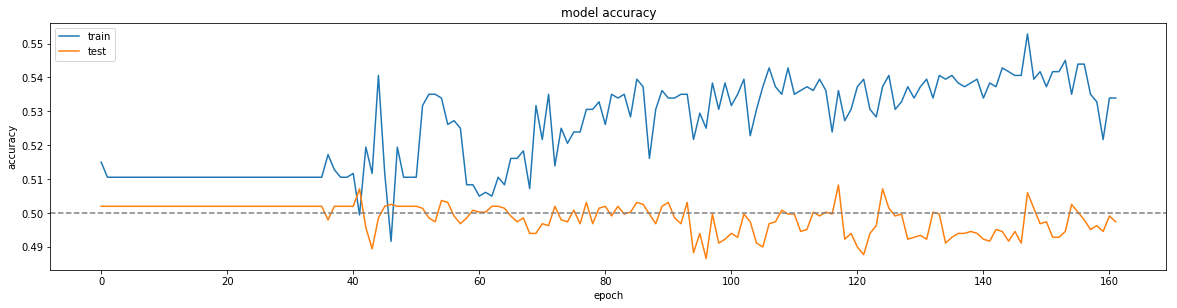

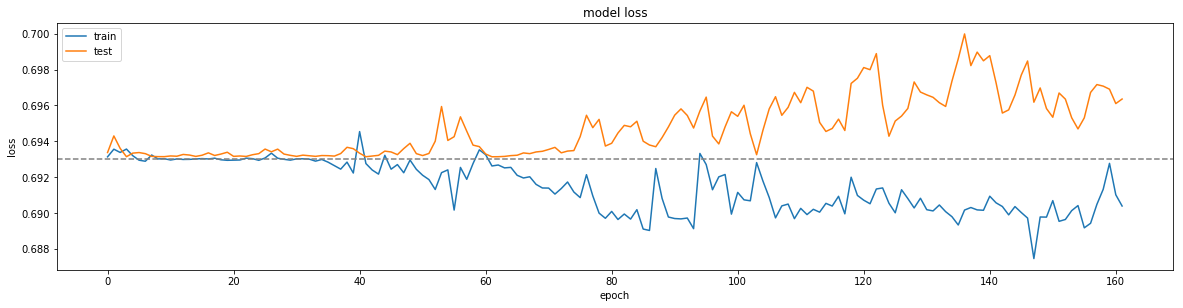

MATTHEWS CORRELATION
0.009536626438521765
CONFUSION MATRIX
[[0.95183486 0.04778157]
 [0.95527523 0.0523322 ]]
CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.50      0.95      0.65       872
          1       0.52      0.05      0.10       879

avg / total       0.51      0.50      0.37      1751

--------------------


In [204]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="testtest.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(patience=100)

#model = get_lr_model(X_train.shape[1], X_train.shape[-1])
# model = get_model(X_train.shape[1], X_train.shape[-1])
model = get_LSTM_model(X_train.shape[1], X_train.shape[-1])
model.summary()

history = model.fit(X_train, Y_train, 
              epochs = 1000, 
              batch_size = 64, 
              verbose=0, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer, es],
              shuffle=True)

model.load_weights('testtest.hdf5')
pred = model.predict(X_test)
plot_history(history)

pred = [1 if p > 0.5 else 0 for p in pred]
C = confusion_matrix(Y_test, pred)

print ('MATTHEWS CORRELATION')
print (matthews_corrcoef(Y_test, pred))
print ('CONFUSION MATRIX')
print ((C / C.astype(np.float).sum(axis=1)))
print ('CLASSIFICATION REPORT')
print (classification_report(Y_test, pred))
print ('-' * 20)

### Preparing Signals (Needs Attention)

In [205]:
pred = [1 if p == 1 else -1 for p in pred] # we need to change NN's 0 output to -1 for our strategy
pred = [p if i % FORECAST == 0 else 0 for i, p in enumerate(pred)]
pred = [0.] * (LOOKBACK) + pred + [0] * FORECAST# first LOOKBACK items needed to make first forecast + items we shifted

In [206]:
class MachineLearningForecastingStrategy():   
    
    def __init__(self, symbol, bars, pred):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = pred
        return signals

In [207]:
class MarketIntradayPortfolio():
    
    def __init__(self, symbol, bars, signals, initial_capital=100000.0, trading_sum = 100):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.trading_sum = float(trading_sum)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.symbol] = self.trading_sum*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
        
        
        portfolio['price_diff'] = self.bars['closeES']-self.bars['openES']
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']

        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

### Backtesting

In [208]:

# preparing for forecasting for tomorrow!
test_set['closeES'] = test_set['closeES'].shift(-FORECAST)

rfs = MachineLearningForecastingStrategy('ES', test_set, pred)
signals = rfs.generate_signals()
portfolio = MarketIntradayPortfolio('ES', test_set, signals, INIT_CAPITAL, STAKE)
returns = portfolio.backtest_portfolio()

/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [209]:
returns['signal'] = signals
our_pct_growth = returns['total'].pct_change().cumsum()
benchmark_ptc_growth = test_set['closeES'].pct_change().cumsum()

### Equity Curve Line

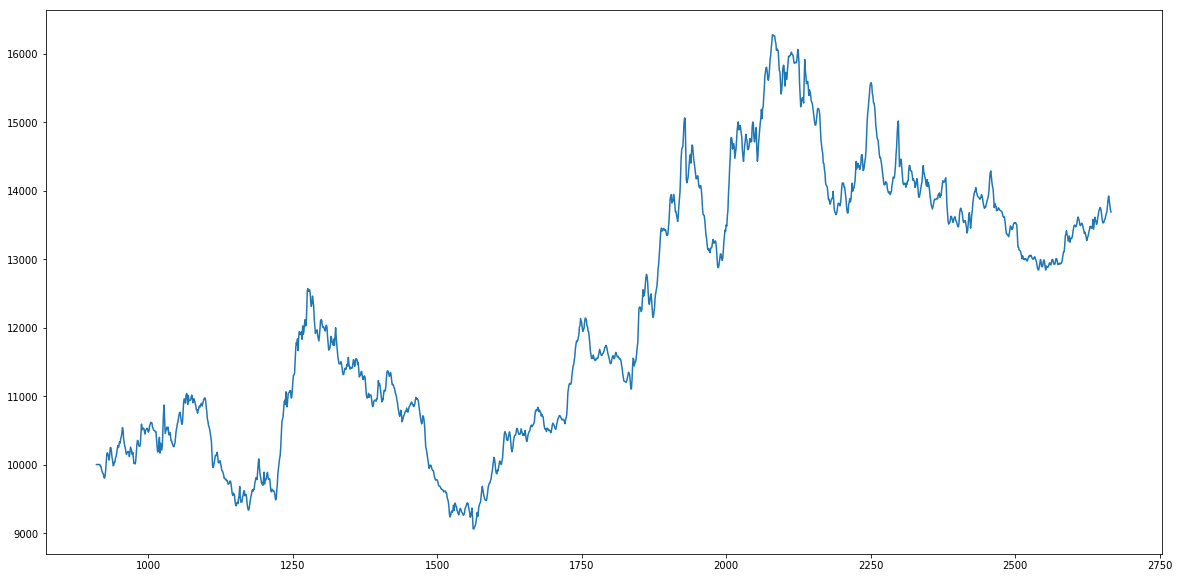

In [210]:
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(returns['total'])
plt.show()

### Benchmarking against Buy and Hold

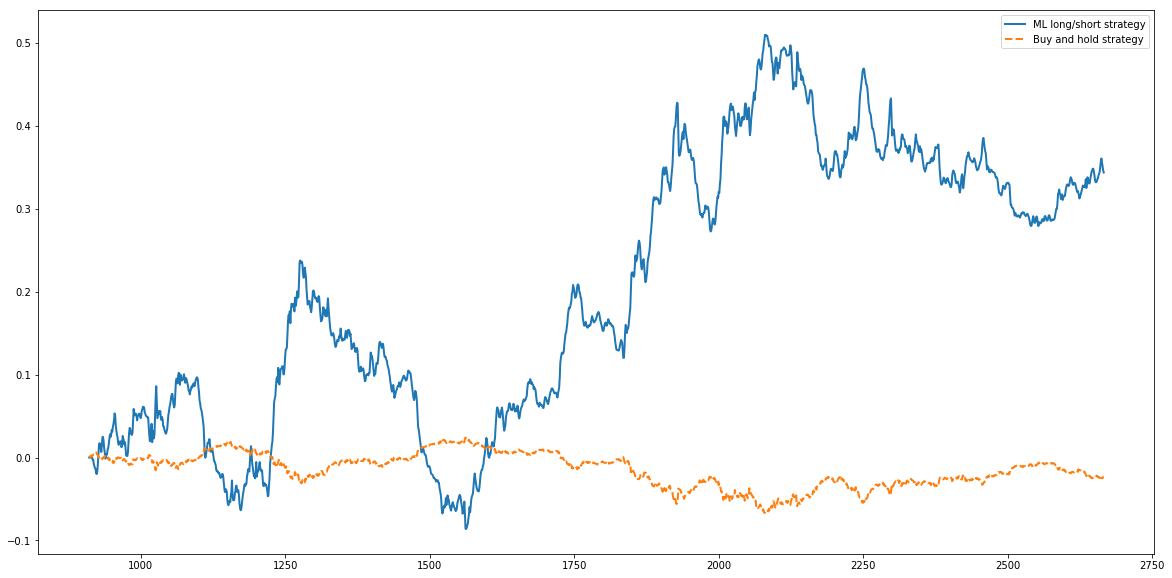

In [211]:
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(our_pct_growth, label = 'ML long/short strategy', linewidth=2)
plt.plot(benchmark_ptc_growth, linestyle = '--', label = 'Buy and hold strategy', linewidth=2)
plt.legend()
plt.show()

### Sharpe Ratio

In [212]:
def sharpe(returns):
    return np.sqrt(len(returns)) * returns.mean() / returns.std()

In [213]:
print (sharpe(our_pct_growth))
print (sharpe(benchmark_ptc_growth))

52.89941296799558
-30.429922239044327


In [202]:
returns.tail()

,price_diff,profit,total,returns,signal
2664,7.25,72.5,9220.0,0.007926,1.0
2665,2.50,25.0,9245.0,0.002711,1.0
2666,3.25,32.5,9277.5,0.003515,1.0
2667,4.50,-45.0,9232.5,-0.004850,-1.0
2668,NaN,NaN,NaN,NaN,0.0
